# Bayesian Inference: *An application to Kinect data*

*by Javier Rico Reche (jvirico@gmail.com)*

[*Online version*](https://www.notion.so/ABM-Assignment-II-1bf730df6f9944f2bc9ecb3804712551)

# Introduction

During this work we perform the classification of sequences of body positions of skeletal body movements recorded from a kinect device.

First we train two Bayesian models, Naïve Bayes and Linear Gaussian Model, the later considering dependencies between the positions of different parts of the skeleton.

Second, we classify a set of new instances using both methods, and finally we evaluate the results giving an Accuracy estimate using Stratified K-Fold Cross-Validation.

### Data

We use a fraction of the [Kinect Gesture Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=52283&from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fum%2Fcambridge%2Fprojects%2Fmsrc12%2F) from Microsoft Research Cambridge, that consists of sequences of human movements, represented as body-part locations, and the associated gesture to be recognized by a system. Although the original dataset contains more than 6h of recordings of 30 people, our subset has 2045 instances of body positions for 4 classes, 'arms lifted', 'right arm extended to one side', 'crouched' and 'right arm extended to the front'.

The data is provided in a .mat Matlab file and loaded in python using *scipy.io.loadmat* function.

It is organized in three data structures:

1. **data**: a matrix (20x3x2045) with information of joints and their corresponding 3D coordinates of 2045 instances.
2. **labels**: a vector (2045x1) with the class label for each instance.
3. **individuals:** a vector (2045x1) with the identification of each individual.

 ## Source Code

### Libraries

In [1]:
import numpy as np 
import math
import random
import scipy.io
from copy import copy, deepcopy
from scipy.stats import lognorm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

### Data structures and classes

In [2]:
# Skeleton definition
NUI_SKELETON_POSITION_COUNT = 20

NONE = -1
HIP_CENTER = 0
SPINE = 1
SHOULDER_CENTER = 2
HEAD = 3
SHOULDER_LEFT = 4
ELBOW_LEFT = 5
WRIST_LEFT = 6
HAND_LEFT = 7
SHOULDER_RIGHT = 8
ELBOW_RIGHT = 9
WRIST_RIGHT = 10
HAND_RIGHT = 11
HIP_LEFT = 12
KNEE_LEFT = 13
ANKLE_LEFT = 14
FOOT_LEFT = 15
HIP_RIGHT = 16
KNEE_RIGHT = 17
ANKLE_RIGHT = 18
FOOT_RIGHT = 19

nui_skeleton_names = ( \
    'HIP_CENTER', 'SPINE', 'SHOULDER_CENTER', 'HEAD', \
    'SHOULDER_LEFT', 'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', \
    'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT', \
    'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT', 'FOOT_LEFT', \
    'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT' )

nui_skeleton_conn = ( \
    NONE, \
    HIP_CENTER, \
    SPINE, \
    SHOULDER_CENTER, \
    # Left arm 
    SHOULDER_CENTER, \
    SHOULDER_LEFT,  \
    ELBOW_LEFT,  \
    WRIST_LEFT,  \
    # Right arm 
    SHOULDER_CENTER,  \
    SHOULDER_RIGHT,  \
    ELBOW_RIGHT,  \
    WRIST_RIGHT,  \
    # Left leg 
    HIP_CENTER,  \
    HIP_LEFT,  \
    KNEE_LEFT,  \
    ANKLE_LEFT,  \
    # Right leg 
    HIP_CENTER,  \
    HIP_RIGHT,  \
    KNEE_RIGHT,  \
    ANKLE_RIGHT,  \
)

In [3]:
## Saving the Skeleton definition
G = []
G.append(nui_skeleton_names)
G.append(nui_skeleton_conn)

In [4]:
## Accessing Skeleton info
print(G[0][1])       #Joint 1 name
print(G[1][1])       #Joint 1 parent
print(G[0][G[1][1]]) #Joint 1 parent name

SPINE
0
HIP_CENTER


### Model Object

The parameters are stored in an object of class *model* as the one below.

In [5]:
# Classes used to build the model structure
class model:
    def __init__(self, G=None):
        self.connectivity = G
        self.class_priors = []
        self.jointparts   = []

class NBJoint:
    def __init__(self):
        self.means  = []
        self.sigmas = []
        
class LGMJoint:
    def __init__(slf):
        slf.HC_means  = []
        slf.HC_sigmas = []
        slf.betas     = []
        slf.sigmas    = []

### Auxiliary Functions

In [6]:
def load_dataset(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/data.mat')
    else:
        ex = scipy.io.loadmat(file)
        
    return ex['data'],ex['labels'],ex['individuals']

In [7]:
def normpdf(x, mu, sigma):
    """
        Computes Normal PDF
    
    """
    p = (1/(sigma*np.sqrt(2*np.pi)))*math.exp(-( ( (x-mu)/sigma )**2 )/2)
    
    return p

In [8]:
def my_normalizator(probs):
    total = 0
    for i in range(0, len(probs)):
        total = total + probs[i]
        
    return (np.divide(probs,total))


In [9]:
print(my_normalizator([2,3,3,4]))

[0.16666667 0.25       0.25       0.33333333]


### Functions for Bayesian Models

In [10]:
def my_cov(x,y,w):
    """
      Useful function for fit_linear_gaussian
    """
    return np.sum(w*x*y)/np.sum(w)-np.sum(w*x)*np.sum(w*y)/np.sum(w)/np.sum(w)


Out Naïve Bayes Model will use a Normal Distribution.

$$P(X|C) = Normal(X;\mu, \sigma^2)$$

See fit_gaussian below:

In [11]:
def fit_gaussian(X, W=None):
    """
      Compute the mean and variance of X, 
      You can ignore W for the moment
    """
    mean = np.mean(X)
    sigma = np.std(X)
    #var = std**2
    
    return (mean, sigma)

Out Linear Gaussian Model will use the following distribution.

$$P(Y|X) = Normal(Y;\beta_{0}+\beta_{1}x_{1}+\beta_{2}x_{2}+...+\beta_{k}x_{k}; \sigma^2)$$

See fit_linear_gaussian below:

In [12]:
def fit_linear_gaussian(Y,X,W = None):
    """
    Input:
      Y: vector of size D with the observations for the variable
      X: matrix DxV with the observations for the parent variables
                 of X. V is the number of parent variables
      W: vector of size D with the weights of the instances (ignore for the moment)
      
    Outout:
       The betas and sigma
    """
    
    #Betas
    D = len(X)
    V = len(X[0])
    b = []
    b.append(np.sum(Y)/D)

    for i in range(0, V):
        b.append(np.sum((Y@X[:,i]))/D)
    
    A = np.zeros((V+1, V+1))
    A[0,0] = 1

    for i in range(0, V):
        A[0,i+1] = np.sum(X[:,i])/D

    for i in range(0, V):
        A[i+1,0] = np.sum(X[:,i])/D

    for i in range(0, V):
        for j in range(0, V):
            A[i+1,j+1] = np.sum((X[:,i]*X[:,j]))/D
    
    betas = np.linalg.solve(A,b)
    
    
    #Sigma
    if (W == None):
        W = np.ones(D)

    s1 = my_cov(Y,Y,W)
    s2 = 0
    N = X.shape[1]

    for i in range(1, N+1):
        for j in range(1, N+1):
            s2 = s2 + betas[i]*betas[j]*my_cov(X[:,i-1],X[:,j-1],W)
    
    sigma = np.sqrt(abs(s1 - s2))
    
    return (betas,sigma)

In [13]:
def learn_model(dataset, labels, G=None):
    """
    Input:
     dataset: The data as it is loaded from load_data
     labels:  The labels as loaded from load_data
     Graph:   (optional) If None, this def should compute the naive 
           bayes model. If it contains a skel description (pe 
           nui_skeleton_conn, as obtained from skel_model) then it should
           compute the model using the Linear Gausian Model

    Output: the model
     a (tentative) structure for the output model is:
       model.connectivity: the input Graph variable should be stored here 
                           for later use.
       model.class_priors: containing a vector with the prior estimations
                           for each class
       model.jointparts[i] contains the estimated parameters for the i-th joint

          For joints that only depend on the class model.jointparts(i) has:
            model.jointparts(i).means: a matrix of 3 x #classes with the
                   estimated means for each of the x,y,z variables of the 
                   i-th joint and for each class.
            model.jointparts(i).sigma: a matrix of 3 x #classes with the
                   estimated stadar deviations for each of the x,y,z 
                   variables of the i-th joint and for each class.

          For joints that follow a gausian linear model model.jointparts(i) has:
            model.jointparts(i).betas: a matrix of 12 x #classes with the
                   estimated betas for each x,y,z variables (12 in total) 
                   of the i-th joint and for each class label.
            model.jointparts(i).sigma: as above

    """
    numClasses = 4
    numJoints = 20
    numCoords = 3
    
    M = model(G)
    
    #Priors
    M.class_priors = [1/numClasses,1/numClasses,1/numClasses,1/numClasses]
    
    #Estimated parameters of Joints
    if(G == None):
          ###############
         # Naïve Bayes #
        ###############
        
        #Single variable
        joint = NBJoint()
        j_m = np.zeros((numCoords,numClasses))
        j_s = np.zeros((numCoords,numClasses))
        
        # Joints loop
        for i in range(0,numJoints):
            # Coordinates loop
            for j in range(0,numCoords):
                # Classes loop
                for k in range(0,numClasses):
                    
                    if(k == 3):
                        clase = 8
                    else:        
                        clase = k+1
                    
                    m,s = fit_gaussian(getInstancesValues(dataset,labels,i,j,clase))
                    j_m[j,k] = m
                    j_s[j,k] = s
            
            joint.means.append(deepcopy(j_m))
            joint.sigmas.append(deepcopy(j_s))
            M.jointparts.append(deepcopy(joint))
            
            j_m = np.zeros((numCoords,numClasses))
            j_s = np.zeros((numCoords,numClasses))
            joint.means  = []
            joint.sigmas = []
        
    else:
          #########################
         # Linear Gaussian Model #
        #########################

        # Single variable
        joint = LGMJoint()
        j_m = np.zeros((numCoords,numClasses))
        j_b = np.zeros((numCoords,numClasses,4))
        j_s = np.zeros((numCoords,numClasses))
        
        # Joints loop
        for i in range(0,numJoints):
            # Coordinates loop
            for j in range(0,numCoords):
                # Classes loop
                for k in range(0,numClasses):
                    
                    if(k == 3):
                        clase = 8
                    else:        
                        clase = k+1
                    
                    Y,X = getInstancesAndParentValues(dataset,labels,i,j,clase,G)
                    
                    if(i == 0):
                        #Special case of HIP_CENTER wich has no parents, we use Mean and Variance
                        m,s = fit_gaussian(Y)
                        
                        j_m[j,k] = m
                        j_s[j,k] = s
                    else:
                        b,s = fit_linear_gaussian(Y,X)
                        
                        j_b[j,k] = np.array(b)
                        j_s[j,k] = s
            
            if(i == 0):
                joint.HC_means.append(deepcopy(j_m))
                joint.HC_sigmas.append(deepcopy(j_s))
            else:
                joint.betas.append(deepcopy(j_b))
                joint.sigmas.append(deepcopy(j_s))
                
            M.jointparts.append(deepcopy(joint))
            
            j_b = np.zeros((numCoords,numClasses,4))
            j_s = np.zeros((numCoords,numClasses))
            joint.betas  = []
            joint.sigmas = []

    return M

In [14]:
def getInstancesValues(data, labels, joint,coordinate,clase):
    """
        Input:
            data: dataset
            labels: labesls dataset
            joint: joint number
            coordinat: x, y or z (0,1 or 2)
            clase: class value (1, 2, 3 or 8)
        Output:
            retorno: Vector with values of a specific
                coordinate (x,y or z) given joint and class.
    """
    retorno = []
    
    for l in range(0,len(labels)):
        if(labels[l]==clase):
            retorno.append(data[joint,coordinate,l])

    return (retorno)

In [15]:
def getInstancesAndParentValues(data, labels, joint, coordinate, clase, G):
    """
        Input:
            data: dataset
            labels: labesls dataset
            joint: joint number
            coordinat: x, y or z (0,1 or 2)
            clase: class value (1, 2, 3 or 8)
            G: skeleton structure
        Output:
            retornoY: Vector with values of a specific
            coordinate (x,y or z) given joint and class.
            retornoX: Vector with values form parent joint.
    """
    retornoY = []
    retornoX = []
    
    N = len(labels)
    PJoint = G[1][joint]
    
    for l in range(0,N):
        if(labels[l]==clase):
            retornoY.append(data[joint,coordinate,l])
            if(PJoint == -1):
                #print("HIP_CENTER")
                retornoX.append(data[joint,coordinate,l])
            else:
                retornoX.append(data[PJoint,:,l])           
    
    return (np.array(retornoY),np.array(retornoX))

In [16]:
def classify_instances(instances, model):
    """    
        Input
           instance: a 20x3x#instances matrix defining body positions of
                     instances
           model: as the output of learn_model

        Output
           probs: a matrix of #instances x #classes with the probability of each
                  instance of belonging to each of the classes

        Important: to avoid underflow numerical issues this computations should
                   be performed in log space
    """

    N = instances.shape[2]
    Nclasses = len(model.class_priors)
    probs = []
    
    # We iterate throught instances
    for i in range(0,N):
        # We calculate the probability of instance ith beloging to each class
        probs.append(compute_logprobs(instances[:,:,i],model))
    
    return np.array(probs)

In [17]:
def GetMu(instance,joint, coord, clase, model):
    """
       Input
           instance: single instance
           joint: joint number
           coord: coordinate index (0, 1 or 2)
           clase: class index
           model: as given by learn_model

       Output
           prbs: calculated mean value
    """
    
    if(joint == 0):
        mu = model.jointparts[0].HC_means[0][coord,clase]
    else:

        parentJoint = model.connectivity[1][joint]

        Xp = instance[parentJoint,0]
        Yp = instance[parentJoint,1]
        Zp = instance[parentJoint,2]

        B0 = model.jointparts[joint].betas[0][coord,clase,0]
        B1 = model.jointparts[joint].betas[0][coord,clase,1]
        B2 = model.jointparts[joint].betas[0][coord,clase,2]
        B3 = model.jointparts[joint].betas[0][coord,clase,3]

        mu = B0 + B1*Xp + B2*Yp + B3*Zp

    return mu

In [18]:
def generate_random_lgm_samples(n, betas, sigma):
    """Function to generate random samples for a 
       Linear Gaussian Model
       Input:
           n: Number of samples
           betas: vector with the values the the betas from 0 to k
           sigma: standard deviation
    """
    X = np.random.randn(n,betas.shape[0]-1)
    Y = np.random.randn(n)*sigma + np.sum(X*betas[1:],axis=1)+betas[0]
    return X,Y

### Functions to compute in Log Space

To avoid underflow numerical issues caused by repeated product operations of small numbers we perform the Posterior's computation in Log Space.

To implement this we use the following functions:

1. ***log_normpdf***: Computes the natural logarithm of the normal probability.
2. ***compute_logprobs***: Computes the log probabilities of an instance.
3. ***normalize_logprobs***: Normalizes log probabilities.

In [19]:
def log_normpdf(x, mean, sigma):
    """
      Computes the natural logarithm of the normal probability density function
      
    """
    prob = -np.log(sigma)-(1/2)*(np.log(2*np.pi))-(1/2)*(((x-mean)/sigma)**2)
    
    return prob


In [20]:
def compute_logprobs(example, model):
    """
       Input
           example: a 20x3 matrix defining body positions of one instance
           model: as given by learn_model

       Output
           prbs: a vector of len #classes containing the loglikelihood of the 
              instance
    """
    
    Nclasses = len(M.class_priors)
    Ncoords = 3
    Njoints = 20
    prbs = []
    prb = []

    if(model.connectivity == None):
        
        # We go through the classes
        for c in range(0,Nclasses):
            # Class prior prob
            prb = np.log(M.class_priors[c])
            
            # We multiply by the likelihood of each joint given parent and class.
            # In Log space we add log probabilities
            for j in range(0,Njoints):
                for i in range(0,Ncoords):

                    x = example[j,i]

                    mu  = model.jointparts[j].means[0][i,c]
                    sig = model.jointparts[j].sigmas[0][i,c]
                    
                    prb = prb + log_normpdf(x, mu, sig)
                    
            prbs.append(prb)  

    else:
    
        # We go through the classes
        for c in range(0,Nclasses):
            # Class prior prob
            prb = np.log(M.class_priors[c])

            # We multiply by the likelihood of each joint given parent and class
            # In Log space we add log probabilities
            for j in range(0,Njoints):
                for i in range(0,Ncoords):

                    x = example[j,i]

                    if(j == 0):
                        mu  = model.jointparts[0].HC_means[0][i,c]
                        sig = model.jointparts[0].HC_sigmas[0][i,c]
                    else:
                        mu = GetMu(example,j, i, c, model)
                        sig = model.jointparts[j].sigmas[0][i,c]

                    prb = prb + log_normpdf(x, mu, sig)
        
            prbs.append(prb)

    return np.array(np.exp(normalize_logprobs(prbs)))


In [21]:
def normalize_logprobs(log_probs):
    """
       Returns the log prob normalizes so that when exponenciated
       it adds up to 1 (Useful to normalizes logprobs)
    """
    mm = np.max(log_probs)
    return log_probs - mm - np.log(np.sum(np.exp(log_probs - mm)))


### Functions to evaluate estimator performance


We use the measurement ***Accuracy*** to compare the methods and the models.
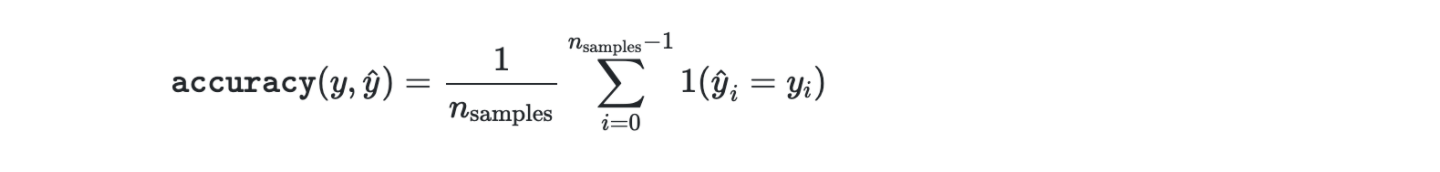
We can see its implementation below:

In [22]:
def Accuracy(predictions, groundTruth):
    """
       Input
           predictions: vector with predicted classes for each instance
           groundTruth: vector with real classes for each instance

       Output
           accuracy: accuracy of prediction
    """
    N = len(predictions)
    y_pred = []
    y_true = groundTruth
    
    for i in range(0,N):
        
        c = np.where(predictions[i] == np.amax(predictions[i]))
        
        if (c[0][0] == 3):
            c = 8
        else:
            c = c[0][0] + 1
        
        y_pred.append(c)
 
    return (accuracy_score(y_true, y_pred,True))

In [23]:
def RandomVect(N, min,max):
    """
       Input
           N: size of vector to generate
           min: minimum value of vector
           max: maximum value of vector

       Output
           retorno: vector with N random (unique) numbers inside range min-max
    """
    
    retorno = []
    finished = False
    ran = 0
    i = 0
    
    while(not finished):
        ran = random.randrange(min, max+1)
        
        if not(ran in retorno):
            retorno.append(ran)
            i = i + 1
            
        if(i == N): finished = True
        
    return retorno

In [24]:
print(RandomVect(10,1,100))

[47, 88, 43, 7, 21, 14, 79, 23, 61, 18]


In [25]:
"""
Stratified k-Fold CrossValidation
"""
def GetPerformance(X, y, n_folds = 4, G = None):
    """
       Input
           X: data
           y: labels
           n_folds: number of folds for K-Fold Cross-Validation
           G: skeleton info

       Output
           model: model object eith model with better accuracy
           measure: better accuracy, corresponds to model returned
           measures: vector with accuracies of all Folds performed,
               it has lenght #n_folds.
    """
    
    skf = StratifiedKFold(n_folds)
    models, measures = [], []
    
    X_ = np.zeros(len(y))
    
    for train_index, test_index in skf.split(X_,y):
        
        ## Extract Kfold
        X_train, X_test = X[:,:,train_index], X[:,:,test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        ## Fit models
        M = learn_model(X_train,y_train, G)
        models.append(learn_model(X_train,y_train, G))
        ## Compute measure
        proba_m = classify_instances(X_test, M)
        Accuracy(probs, labels_test)
        measures.append(Accuracy(proba_m, y_test))

    i = np.argmax(measures)
    model, measure = models[i], measures[i]
    return model, measure, measures

## End of definitions - Code executions

### Testing learned model functionality

In [26]:
 # Testing GetMu #
#################
data,labels,individuals = load_dataset()
data_train = data[:,:,0:int(2045*0.8)]   #1636 of instances (80%) to train model
data_test = data[:,:,int(2045*0.8):2045] #409 of instances (20%) to evaluate model
labels_train = labels[0:int(2045*0.8)]
labels_test = labels[int(2045*0.8):2045]

M = learn_model(data_train,labels_train,G)

mu = GetMu(data[:,:,0],2, 0, 1, M)
mu

0.10568026257482874

In [27]:
 # Printing Naïve Bayes model #
##############################
data,labels,individuals = load_dataset()
m = learn_model(data,labels)

for i in range(0, 20):
    print(i)
#    for j in range(0, 3):
    print('Means:')
    print(m.jointparts[i].means[0])
    print('Sigmas:')
    print(m.jointparts[i].sigmas[0])

0
Means:
[[ 0.01112212 -0.01737053 -0.03560072 -0.1022157 ]
 [ 0.18124251 -0.43052049  0.13204696  0.13630162]
 [ 2.85197619  2.85893658  2.83214059  2.63312742]]
Sigmas:
[[0.11684439 0.13480722 0.12590237 0.149213  ]
 [0.09502697 0.10523837 0.08837552 0.0926438 ]
 [0.18857258 0.21078747 0.24108265 0.28238917]]
1
Means:
[[ 0.01083158 -0.01739497 -0.03400122 -0.09851582]
 [ 0.24235283 -0.38530225  0.19924413  0.20401199]
 [ 2.8864795   2.83167166  2.86767057  2.65532527]]
Sigmas:
[[0.11943067 0.13416078 0.12819645 0.14952076]
 [0.0969737  0.10677718 0.09008805 0.0950633 ]
 [0.18145818 0.20940876 0.23704666 0.28819055]]
2
Means:
[[ 0.01374415 -0.01706751 -0.02952214 -0.1313279 ]
 [ 0.5740649  -0.16192242  0.55733611  0.55160436]
 [ 2.87825109  2.70663207  2.85304254  2.62372971]]
Sigmas:
[[0.12154389 0.13433178 0.13316234 0.15133611]
 [0.10389168 0.12209005 0.09798363 0.1128473 ]
 [0.17965779 0.21224576 0.23622663 0.30221824]]
3
Means:
[[ 0.01617589 -0.01180968 -0.02698633 -0.16865735]
 

In [28]:
 # Testing learn_model #
#######################

data,labels,individuals = load_dataset()
m = learn_model(data,labels,G)

print('Special case of HIP_CENTER')
print('Means')
print(m.jointparts[0].HC_means[0][0,0]) #jointparts[ <<joint>> ].HC_means[0][<<x,y,z>>,<<class(0-3)>>]
print('Sigmas')
print(m.jointparts[0].HC_sigmas[0][0,0])
print()

print('Betas')
print(m.jointparts[1].betas[0]) #jointparts[ <<joint>> ].betas[0][<<x,y,z>>,<<class(0-3)>>,<<beta(0-3)>>]
print('Sigmas')
print(m.jointparts[1].sigmas[0])

Special case of HIP_CENTER
Means
0.011122120078740158
Sigmas
0.11684439406137646

Betas
[[[ 6.86024005e-03  1.01999064e+00 -1.84209844e-03 -2.46819986e-03]
  [ 1.39553237e-03  9.95810413e-01  6.81524334e-03  5.04159543e-04]
  [ 9.57077564e-03  1.01803251e+00  1.33723213e-02 -3.21137723e-03]
  [-3.50960597e-02  1.01270875e+00 -8.89966734e-03  1.56878144e-02]]

 [[ 4.45088373e-02 -4.93703006e-04  1.01592983e+00  4.81063439e-03]
  [ 4.07484899e-02  6.11734789e-03  1.01222576e+00  3.44164473e-03]
  [ 6.43680057e-02  5.74098790e-05  1.01862114e+00  1.31471332e-04]
  [ 5.85507308e-02 -8.80639312e-04  1.02135510e+00  2.33900063e-03]]

 [[ 1.69426531e-01 -3.79209328e-02 -1.41988073e-02  9.53741536e-01]
  [-1.07805527e-02  1.41194281e-02  3.03523612e-03  9.94776950e-01]
  [ 1.20631066e-01 -6.39881040e-02 -3.71791121e-02  9.70880783e-01]
  [-1.84796978e-02 -7.28869531e-03 -5.05545544e-03  1.01542713e+00]]]
Sigmas
[[0.00380429 0.00563751 0.00404109 0.01128487]
 [0.00477928 0.00776929 0.0034189  0

In [29]:
 # Testing fit_linear_gaussian 1 #
#################################

betas = np.array([1,2,10,4,5,6])
sigma = 0.1
n=100
X,Y=generate_random_lgm_samples(n,betas,sigma)

# This following call should output  betas and sigma close to the above ones
b, s = fit_linear_gaussian(Y,X)

print( 'GT_Betas: ' + str(betas))
print ('My_Betas: ' + str(b))
print('GT_Sigma: ' + str(sigma))
print ('My_Sigma: ' + str(s))

GT_Betas: [ 1  2 10  4  5  6]
My_Betas: [0.99926501 1.98761131 9.98851481 3.99070043 5.00334655 6.0006243 ]
GT_Sigma: 0.1
My_Sigma: 0.10500603063835766


In [30]:
 # Testing fit_linear_gaussian 2 #
#################################

import scipy.io

dd = scipy.io.loadmat('data/ejemplolineargaussian.mat')
dd = dd['ejemplo'][0]
# The inputs are
X = dd['inputX']
Y = dd['inputY']
X = X[0]
Y = Y[0][:,0]
# The expected outputs are
betas = dd['outputBetas']
sigma = dd['outputSigma']

### Mine
data,labels,individuals = load_dataset()
#Y_,X_ = getInstancesAndParentValues(data,labels,1,1,1,G)

b,s = fit_linear_gaussian(Y,X)
print('GT_Betas:' + str(betas[0][:,0]))
print('My_Betas:' + str(b))

print('GT_Sigma: ' + str(sigma[0][:,0]))
print('My_Sigma: ' + str(s))

GT_Betas:[ 1.00264759e+00 -2.29891432e-03  5.80448903e-02 -4.56929038e+00]
My_Betas:[-4.56929038e+00  1.00264759e+00 -2.29891432e-03  5.80448903e-02]
GT_Sigma: [1.52449884]
My_Sigma: 1.5244988379202242


In [31]:
 # Testing fit_gaussian #
#######################

V = np.array([1,2,10,4,5,6])

mean, var = fit_gaussian(V)

print(mean)
print(var)

4.666666666666667
2.9249881291307074


In [32]:
 # NB Model data validation #
############################

dd = scipy.io.loadmat('data/validation_data.mat')
data = dd['data_small'] # Input data
labels = dd['labels_small'] # Input labels
individuals = dd['individuals_small'] # Input individual indexes
dd['train_indexes'] # Instances used for training
dd['test_indexes']  # Instances used for test
dd['model_nb']      # NB model
dd['model_lg']      # LG model
dd['accur_nb']      # Accuracy of NB model on test instances
dd['accur_lg']      # Accuracy of LG model on test instances

### Mine
data_ori,labels_ori,individuals_ori = load_dataset()
m = learn_model(data,labels)
with np.printoptions(precision=3, suppress=True):
    for i in range(0,20):
        print('## Joint '+ str(i) + ' ##')
        print('My_Means:')
        print(m.jointparts[i].means[0])
        print('GT_Means: ')
        print(str(dd['model_nb'][0,0][0][0][i][0]))
        print()

        print('My_Sigmas_:')
        print(m.jointparts[i].sigmas[0])
        print('GT_Sigmas: ')
        print(str(dd['model_nb'][0,0][0][0][i][1]))

        print()
        print()


## Joint 0 ##
My_Means:
[[ 0.002 -0.036 -0.052 -0.095]
 [ 0.181 -0.418  0.125  0.135]
 [ 2.839  2.879  2.84   2.662]]
GT_Means: 
[[ 0.017 -0.023 -0.025 -0.086]
 [ 0.184 -0.425  0.127  0.14 ]
 [ 2.837  2.866  2.84   2.649]]

My_Sigmas_:
[[0.117 0.127 0.123 0.142]
 [0.092 0.101 0.087 0.087]
 [0.19  0.202 0.242 0.275]]
GT_Sigmas: 
[[0.114 0.122 0.113 0.127]
 [0.1   0.119 0.095 0.099]
 [0.162 0.189 0.212 0.198]]


## Joint 1 ##
My_Means:
[[ 0.002 -0.034 -0.05  -0.09 ]
 [ 0.243 -0.374  0.193  0.203]
 [ 2.876  2.848  2.875  2.687]]
GT_Means: 
[[ 0.017 -0.021 -0.022 -0.081]
 [ 0.246 -0.38   0.196  0.208]
 [ 2.873  2.836  2.872  2.673]]

My_Sigmas_:
[[0.119 0.126 0.125 0.143]
 [0.094 0.102 0.089 0.089]
 [0.184 0.198 0.238 0.275]]
GT_Sigmas: 
[[0.115 0.119 0.116 0.127]
 [0.102 0.12  0.097 0.1  ]
 [0.155 0.186 0.208 0.205]]


## Joint 2 ##
My_Means:
[[ 0.004 -0.026 -0.046 -0.124]
 [ 0.575 -0.156  0.554  0.558]
 [ 2.867  2.705  2.86   2.664]]
GT_Means: 
[[ 0.019 -0.01  -0.015 -0.122]
 [ 0.583 -0.

In [33]:
 # LGM Model data validation #
#############################

dd = scipy.io.loadmat('data/validation_data.mat')
data = dd['data_small'] # Input data
labels = dd['labels_small'] # Input labels
individuals = dd['individuals_small'] # Input individual indexes
dd['train_indexes'] # Instances used for training
dd['test_indexes']  # Instances used for test
dd['model_nb']      # NB model
dd['model_lg']      # LG model
dd['accur_nb']      # Accuracy of NB model on test instances
dd['accur_lg']      # Accuracy of LG model on test instances

### Mine
data_ori,labels_ori,individuals_ori = load_dataset()
m = learn_model(data,labels,G)
with np.printoptions(precision=3, suppress=True):
        
    print('## Joint '+ str(0) + ' ##')
    print('My_HCMeans:')
    print(m.jointparts[0].HC_means[0])
    print('GT_HCMeans: ')
    print(str(dd['model_lg'][0,0][0][0][0][0]))
    print()

    print('My_HCSigmas:')
    print(m.jointparts[0].HC_sigmas[0])
    print('GT_HCSigmas: ')
    print(str(dd['model_lg'][0,0][0][0][0][1]))

    print()
    print()   
    
    for i in range(1,20):
        print('## Joint '+ str(i) + ' ##')
        print('My_Betas:')
        print(m.jointparts[i].betas[0])
        print('GT_Betas: ')
        print(str(dd['model_lg'][0,0][0][0][i][0]))
        print()

        print('My_Sigmas_:')
        print(m.jointparts[i].sigmas[0])
        print('GT_Sigmas: ')
        print(str(dd['model_lg'][0,0][0][0][i][1]))

        print()
        print()

## Joint 0 ##
My_HCMeans:
[[ 0.002 -0.036 -0.052 -0.095]
 [ 0.181 -0.418  0.125  0.135]
 [ 2.839  2.879  2.84   2.662]]
GT_HCMeans: 
[[ 0.017 -0.023 -0.025 -0.086]
 [ 0.184 -0.425  0.127  0.14 ]
 [ 2.837  2.866  2.84   2.649]]

My_HCSigmas:
[[0.117 0.127 0.123 0.142]
 [0.092 0.101 0.087 0.087]
 [0.19  0.202 0.242 0.275]]
GT_HCSigmas: 
[[0.114 0.122 0.113 0.127]
 [0.1   0.119 0.095 0.099]
 [0.162 0.189 0.212 0.198]]


## Joint 1 ##
My_Betas:
[[[ 0.009  1.018  0.008 -0.004]
  [ 0.01   0.993  0.013 -0.001]
  [ 0.007  1.022  0.008 -0.002]
  [-0.033  1.015 -0.016  0.015]]

 [[ 0.038  0.006  1.021  0.007]
  [ 0.042  0.006  1.007  0.002]
  [ 0.065  0.001  1.02   0.   ]
  [ 0.046  0.005  1.014  0.008]]

 [[ 0.172 -0.05  -0.015  0.953]
  [ 0.019  0.007  0.006  0.984]
  [ 0.117 -0.062 -0.082  0.973]
  [ 0.051 -0.016 -0.099  0.995]]]
GT_Betas: 
[[ 0.003  0.002  0.002 -0.02 ]
 [ 1.013  0.983  1.027  0.993]
 [ 0.005  0.012  0.015 -0.012]
 [-0.002  0.002 -0.     0.01 ]
 [ 0.044  0.037  0.071  0.06 ]

# Evaluation

An evaluation of both, Naïve Bayes and Linear Gaussian Model have been performed using the following methods:

1. **Sequential Holdout** 80/20 split.
2. **Random Holdout** 80/20 split.
3. **Stratified 4-Fold Cross-validation**.

### Sequential Holdout

We use a split of 80% instances to build the training dataset and 20% for the testing dataset. The separation is done sequentially, therefore it does not consider that the instances of the original dataset have a specific order, and that instances of a specific class are mostly grouped together.

Since the method does not split in train and test datasets with data representing equally all classes, this method is the weakest one as we will see in the Results section.

In [34]:
##
## Naïve Bayes Model
##
## Sequential Holdout 80/20 split

data,labels,individuals = load_dataset()

data_train = data[:,:,0:int(2045*0.8)]   #1636 of instances (80%) to train model
data_test = data[:,:,int(2045*0.8):2045] #409 of instances (20%) to evaluate model

labels_train = labels[0:int(2045*0.8)]
labels_test = labels[int(2045*0.8):2045]

M = learn_model(data_train,labels_train)
probs = classify_instances(data_test, M)

A = Accuracy(probs, labels_test)
A

0.7579462102689487

In [35]:
##
## Linear Gaussian Model
##
## Sequential Holdout 80/20 split

data,labels,individuals = load_dataset()

data_train = data[:,:,0:int(2045*0.8)]   #1636 of instances (80%) to train model
data_test = data[:,:,int(2045*0.8):2045] #409 of instances (20%) to evaluate model

labels_train = labels[0:int(2045*0.8)]
labels_test = labels[int(2045*0.8):2045]

M = learn_model(data_train,labels_train,G)
probs = classify_instances(data_test, M)


A = Accuracy(probs, labels_test)
A

0.7970660146699267

### Random Holdout

For the generation of Random index vectors without repetitions we use the function ***RandomVect:***

We use again a split of 80% instances to build the training dataset and 20% for the testing dataset. 

This time the separation of instances is done randomly using ***RandomVect***, therefore we minimize the previous problem of not representing all clases in the train and test datasets equally.

No repetitions of instances is used in the process of splitting into train and test datasets.

In [36]:
##
## Naïve Bayes Model
##
## Random Holdout 80/20 split

data,labels,individuals = load_dataset()

shuffledIndex = RandomVect(2045,0,2044)

data_train = data[:,:,shuffledIndex[0:int(2045*0.8)]]   #1636 of instances (80%) to train model
data_test = data[:,:,shuffledIndex[int(2045*0.8):2045]] #409 of instances (20%) to evaluate model

labels_train = labels[shuffledIndex[0:int(2045*0.8)]]
labels_test = labels[shuffledIndex[int(2045*0.8):2045]]

M = learn_model(data_train,labels_train)
probs = classify_instances(data_test, M)


A = Accuracy(probs, labels_test)
A

0.9437652811735942

In [37]:
##
## Linear Gaussian Model
##
## Random Holdout 80/20 split

data,labels,individuals = load_dataset()

shuffledIndex = RandomVect(2045,0,2044)

data_train = data[:,:,shuffledIndex[0:int(2045*0.8)]]   #1636 of instances (80%) to train model
data_test = data[:,:,shuffledIndex[int(2045*0.8):2045]] #409 of instances (20%) to evaluate model

labels_train = labels[shuffledIndex[0:int(2045*0.8)]]
labels_test = labels[shuffledIndex[int(2045*0.8):2045]]

M = learn_model(data_train,labels_train, G)

probs = classify_instances(data_test, M)

A = Accuracy(probs, labels_test)
A

0.9853300733496333

### Stratified 4-Fold Cross-validation

To solve the problem of not representing all clases equally for train and test datasets we introduce Stratification, and a 4 Fold Cross-validation, assuring that the folds preserve the percentage of samples for each class.

To control the Cross-validation iterations we use the function ***GetPerformance***

In [38]:
##
## Naïve Bayes Model
##
## Stratified Crossvalidation 4Fold

data,labels,individuals = load_dataset()
[M, A, measures] = GetPerformance(data, np.concatenate(labels), 4)

print("Accuracies       = " + str(measures))
print("Best Accuracy    = " + str(A))
print("Average Accuracy = " + str(np.average(measures)))

Accuracies       = [0.9765625, 0.9197651663405088, 0.9804305283757339, 0.9021526418786693]
Best Accuracy    = 0.9804305283757339
Average Accuracy = 0.9447277091487281


In [39]:
##
## Linear Gaussian Model
##
## Stratified Crossvalidation 4Fold

data,labels,individuals = load_dataset()
[M, A, measures] = GetPerformance(data, np.concatenate(labels), 4, G)

print("Accuracies       = " + str(measures))
print("Best Accuracy    = " + str(A))
print("Average Accuracy = " + str(np.average(measures)))

Accuracies       = [1.0, 0.9569471624266145, 0.9784735812133072, 0.9452054794520548]
Best Accuracy    = 1.0
Average Accuracy = 0.9701565557729941


# Results

As we can observe in the table '*Accuracy Table*' below, **Linear Gaussian Model outperforms Naïve Bayes** **Model** with all evaluation methods used. Being the former a Discriminative model that considers conditional probabilities (parent joints), and the later a Generative model with a more simplistic view of the data (strong variables independence), the results are congruent.

Regarding the method of validation, **Stratified Cross-validation** is clearly the **more robust** method we have used and therefore more reliable than Random Holdout. Although the results are similar on both methods, Cross-validation is usually the preferred because it gives the model the opportunity to train on multiple train-test splits.

This gives us a better indication of how well the model will perform on unseen data. Hold-out, on the other hand, is dependent on just one train-test split.

Regarding Sequential or Random Holdout, as we have mentioned before, splitting the data randomly produces a more 'fair' model than a sequential split, specially considering that the instances in the original dataset are grouped by classes. We can see, comparing Sequential Holdout and Random Holdout, that the results clearly support this. 

Finally, **Stratification** ensures even greater 'fairness' regarding to equal representation of classes in all datasets and folds.

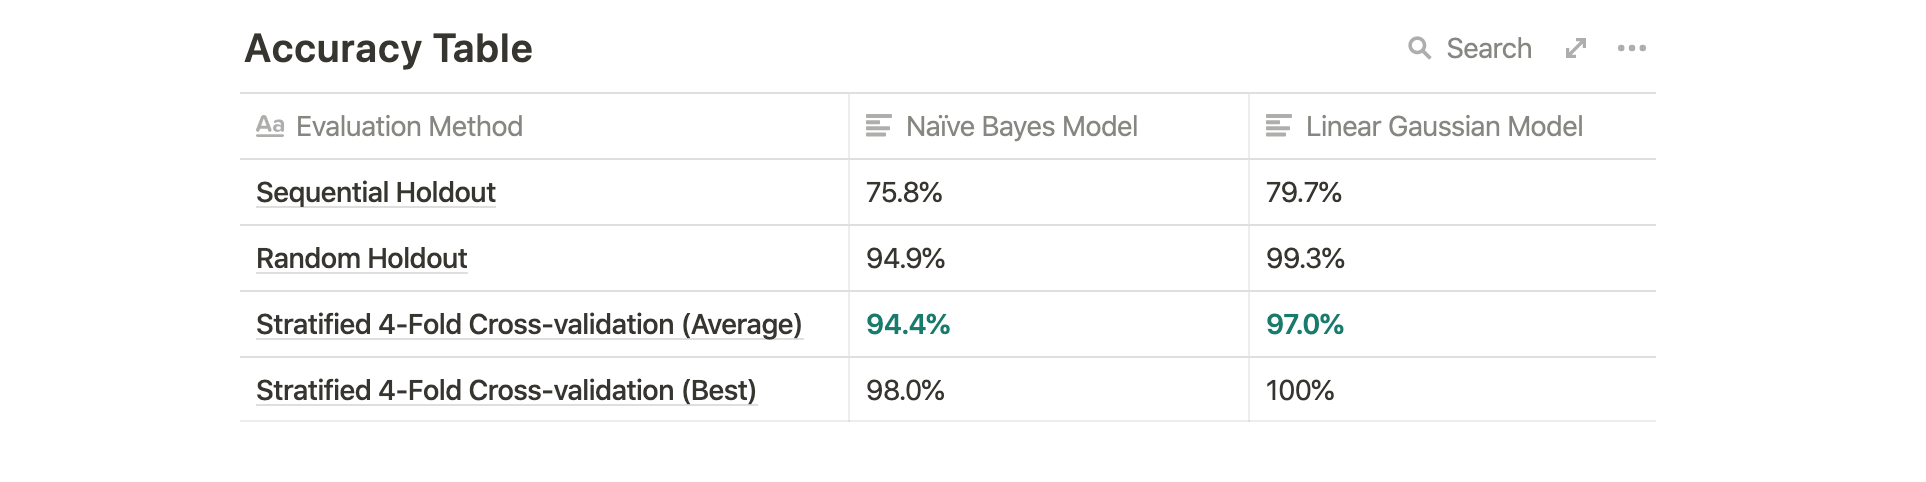

# Conclusions

Regardless the naïve aspect of Naïve Bayes, and having into account that strong conditional independence assumptions rarely hold true, we observe good performance for this model, achieving a good balance between accuracy and simplicity of implementation.

Nevertheless, introducing dependencies between the positions of different parts of the skeleton makes Linear Gaussian Model outperform the Naïve Bayes approach.

Notice the importance to perform the calculation of the posteriors in Log Space to avoid floating point underflows, and ending up dealing with numbers of smaller absolute value than the computer can actually represent.